# Defining, predicting, and preventing disengaged users for Fintech Apps (Part 1: ML Approach)

Part I of of this manuscript covers:
1. Problem statement
2. Defining engagement
3. Predicting engagement
4. Model evaluation

Part II will cover:  
5. Designing intervention (contextual recommender system)  
6. Designing A/B Testing  
7. Evaluating and interpreting the results

# About Fintech 
Fintech, a highly used buzzword, represent the digital transformation disruption in the finance industry. Startups like Wise (formerly known as Transferwise), Monzo, and many others, started with remittance and money transfer services and grown into borderless digital bank. Competitions in fintech are getting more crowded, with more prominent players like Google and Apple joined the revolution. 

To survive the competition, fintech institutions gauge different strategies. Some expanded the service and embrace cryptocurrencies, and some others work together in a symbiotic relationship. One example is the integration of Wise and Google Pay to enable their user base to send money overseas. Just like almost B2C business models, one common strategy to survive, is to keep their current user happy and continue using the service regularly.  

This exercise demonstrated a practical machine learning approach to address this issue. Using the historical data, we aim to identify disengaged users, predict their future engagement and design an intercept to prevent dropout.


# Data 
The data consist of a synthesized users' historical transactions. The main goal of this exercise is to demonstrate the methods and approaches in addressing the issue and less about the data itself. The data consist of a detailed transaction log (inbound, outbound, fee, etc) for each customer in a 19 months timeframe, which includes transaction amount, timestamp, status, and basic demographic and location.


In [1]:
from pyspark.sql import functions as f, SparkSession, DataFrame, Window
from pyspark.sql.functions import col, lit, udf
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import pickle

In [2]:
# Configuration and set up

spark = (SparkSession.builder.master("local[*]")
                     .config("spark.sql.repl.eagerEval.enabled", True)
                     .getOrCreate())


'''
Avoid recalculating everytime the notebook is run. Read from the saved feature instead.
Change to False, if features are already computed.

RECOMPUTE = True 
'''

RECOMPUTE = True 
figsize = (16,5)

RAW_DATA = 'data/raw_data'
FEATURES_PATH = 'data/features/features.parquet'

In [46]:
transaction = spark.read.option('compression', 'gzip').option('inferSchema', 'true').csv(RAW_DATA, header=True)
transaction.limit(5)

user_id,birth_year,home_country,home_city,device,num_contacts,plan,num_successful_referrals,joined_date,transaction_id,created_date,merchant_country,merchant_city,card_presence,direction,transactions_type,transactions_state,amount_usd
015aff8c321742c6b...,1992,SR,New Cassandra,Apple,8,STANDARD,0,2018-06-16 02:33:...,ae3a61b8c0254daca...,2018-06-15 06:41:...,null,null,null,INBOUND,TOPUP,COMPLETED,6.29
015aff8c321742c6b...,1992,SR,New Cassandra,Apple,8,STANDARD,0,2018-06-16 02:33:...,5f8f57ed3aa74775a...,2018-06-16 00:16:...,null,null,null,INBOUND,TOPUP,REVERTED,1.36
015aff8c321742c6b...,1992,SR,New Cassandra,Apple,8,STANDARD,0,2018-06-16 02:33:...,7986278db1824634a...,2018-06-16 01:37:...,null,null,null,OUTBOUND,FEE,COMPLETED,6.36
015aff8c321742c6b...,1992,SR,New Cassandra,Apple,8,STANDARD,0,2018-06-16 02:33:...,596f2f7d24754ef48...,2018-06-18 03:09:...,null,null,null,INBOUND,TOPUP,COMPLETED,13.3
015aff8c321742c6b...,1992,SR,New Cassandra,Apple,8,STANDARD,0,2018-06-16 02:33:...,6f8ad9c8af9a40fdb...,2018-06-28 00:50:...,BR,da Rosa,FALSE,OUTBOUND,CARD_PAYMENT,COMPLETED,2.84


In [4]:
from fintech.features import activity, demographic, location, recency
from pyspark.ml import Pipeline


def generateFeatures(transaction, users):
    feature_list = [
        # HISTORICAL ACTIVITIES
        activity.f_user_transcAmount_min(transc_table=transaction),
        activity.f_user_transcAmount_max(transc_table=transaction),
        activity.f_user_transcAmount_total(transc_table=transaction),
        activity.f_user_transcAmount_avg(transc_table=transaction),

        # TIME AND RECENCY 
        recency.f_user_daysSinceLastTransc(transc_table=transaction),
        recency.f_user_transcCurrMonth_count(transc_table=transaction),
        recency.f_user_transcPrevMonth_count(transc_table=transaction),
        recency.f_transcByDayOfWeek_ratio(transc_table=transaction),
        recency.f_transcByTimeOfDay_ratio(transc_table=transaction),
        recency.f_user_merchantTranscLastMonth_count(transc_table=transaction),
        recency.f_user_nonMerchantTranscCurrMonth_count(
            transc_table=transaction),
        recency.f_user_transcAmountCurrMonth_total(transc_table=transaction),
        recency.f_user_transcAmountPrevMonth_total(transc_table=transaction),
        recency.f_user_transcByDirectionCurrMonth_count(
            transc_table=transaction),
        recency.f_user_transcByDirectionPrevMonth_count(
            transc_table=transaction),
        recency.f_user_transcByStatusCurrMonth_count(transc_table=transaction),
        recency.f_user_transcByStatusPrevMonth_count(transc_table=transaction),
        recency.f_user_transcByTypeCurrMonth_count(transc_table=transaction),
        recency.f_user_transcByTypePrevMonth_count(transc_table=transaction),

        # LOCATION
        location.f_user_localTranscAmount_avg(transc_table=transaction),
        location.f_user_intlTranscAmount_avg(transc_table=transaction),
        location.f_user_freqIntlTransc_ratio(transc_table=transaction),
        location.f_user_freqLocalTransc_ratio(transc_table=transaction),
        location.f_user_topForeign_country(transc_table=transaction),
        location.f_user_topMerchant_city(transc_table=transaction),

        # PREFERENCES AND DEMOGRAPHIC
        demographic.f_user_ageBucket(transc_table=transaction),
        demographic.f_user_plan(),
        demographic.f_user_daysSinceJoined(transc_table=transaction),
        demographic.f_user_daysSinceLastTransc_quantiles(
            transc_table=transaction),
        demographic.f_user_contact_count(),
        demographic.f_user_device(),
        demographic.f_user_home_city(),
        demographic.f_user_home_country()
    ]

    _feat_cols = [[i.feature_names] if isinstance(
        i.feature_names, str) else i.feature_names for i in feature_list]
    feature_columns = ["user_id"] + list(itertools.chain(*_feat_cols))

    feature_pipeline = Pipeline(stages=feature_list)
    features = (feature_pipeline.fit(users)
                                .transform(users)
                                .select(feature_columns))

    return features


# batch is scheduled to run at the 1st day of next month
monthly_batches = (transaction.select(f.trunc(f.add_months("created_date", 1), "month").alias("month"))
                  .distinct()
#                    .where(f.col('month')>f.lit('2019-02-01').cast('date'))
                   .orderBy("month").toPandas().month.to_list())

if RECOMPUTE:
    
    for current_batch in monthly_batches:
            batch_id = current_batch.strftime("%Y-%m")

            ## Filter
            user_cols = ['user_id', 'birth_year','home_country', 'home_city', 'device', 
                         'num_contacts', 'plan', 'num_successful_referrals', 'joined_date',]
            batch_transaction = transaction.filter(
                col("created_date").cast("date") < lit(current_batch).cast("date"))
            batch_users = (transaction.filter(col("joined_date").cast(
                "date") < lit(current_batch).cast("date")).select(*user_cols).distinct())
            
            ## Temp files to address Out of Memory Issues for Laptop
            ## Can be safely removed if not needed
            batch_transaction.write.mode('overwrite').parquet('data/tmp/batch_transaction.parquet')
            batch_transaction = spark.read.parquet('data/tmp/batch_transaction.parquet')
            batch_users.write.mode('overwrite').parquet('data/tmp/batch_user.parquet')
            batch_users = spark.read.parquet('data/tmp/batch_user.parquet')
            
            
            ## Feature extraction
            features_data = generateFeatures(
                transaction=batch_transaction, users=batch_users)
            features_data.select(lit(batch_id).alias('batch_id'),
                                 '*').write.mode('append').parquet(FEATURES_PATH)
            print(batch_id, ' completed')


else:
    for current_batch in monthly_batches:
            batch_id = current_batch.strftime("%Y-%m")
            print(batch_id, " completed")

2018-02  completed
2018-03  completed
2018-04  completed
2018-05  completed
2018-06  completed
2018-07  completed
2018-08  completed
2018-09  completed
2018-10  completed
2018-11  completed
2018-12  completed
2019-01  completed
2019-02  completed
2019-03  completed
2019-04  completed
2019-05  completed
2019-06  completed


In [5]:
from pyspark.ml import Pipeline as sparkPipeline
from pyspark.ml.feature import StringIndexer


feature_data = spark.read.parquet(FEATURES_PATH)

to_impute_with_zero = (#['user_allowEmail', 'user_allowPush'] +
                       [column for column in feature_data.columns if column.endswith("_count")
                        or column.endswith("_ratio") or column.endswith("_avg")])

to_impute_withNA = ['user_topForeign_country', 'user_topMerchant_city']

categorical = ['user_topForeign_country',
               'user_topMerchant_city',
               'user_ageBucket',
               'user_plan',
               'user_device',
               'user_home_city',
               'user_home_country']

standarize = ["user_transcAmount_avg",
              "user_transcAmount_min",
              "user_transcAmount_max",
              "user_transcAmountCurrMonth_total",
              "user_transcAmountPrevMonth_total"]

features = (feature_data
            .drop("user_merchantTranscLastMonth_total",
                  "user_nonMerchantTranscCurrMonth_total",
                  "user_transcAmount_total")
            .withColumn("user_contact_count", col("user_contact_count").cast("int"))
            .fillna(0, subset=to_impute_with_zero)
            .fillna("N/A", subset=to_impute_withNA)
            .withColumn("user_isDropOut_currentMonth", (col("user_daysSinceLastTransc")
                                                        > col("user_daysBtwTransc_90q").cast("int")))
            .withColumn("user_isDropOut_nextMonth", f.lag("user_isDropOut_currentMonth", -1)
                        .over(Window.partitionBy("user_id").orderBy("batch_id")))
            .filter((col("user_transcAmount_total") > 0) &
                    col("user_isDropOut_currentMonth").isNotNull() &
                    col("user_isDropOut_nextMonth").isNotNull())
            .drop('user_isDropOut_currentMonth')
           )


indexers = [StringIndexer(inputCol=column, outputCol="%s_" % column)
            for column in categorical]

string_indexer = sparkPipeline(stages=indexers).fit(features)

X = string_indexer.transform(features).drop(*categorical)

display(features.describe())

summary,batch_id,user_id,user_transcAmount_min,user_transcAmount_max,user_transcAmount_avg,user_daysSinceLastTransc,user_transcCurrMonth_count,user_transcPrevMonth_count,user_transactionOnMonday_ratio,user_transactionOnTuesday_ratio,user_transactionOnWednesday_ratio,user_transactionOnThursday_ratio,user_transactionOnFriday_ratio,user_transactionOnSaturday_ratio,user_transactionOnSunday_ratio,user_transactionOnMorning_ratio,user_transactionOnAfternoon_ratio,user_transactionOnEvening_ratio,user_merchantTranscLastMonth_count,user_nonMerchantTranscCurrMonth_count,user_transcAmountCurrMonth_total,user_transcAmountPrevMonth_total,user_inboundCurrMonth_count,user_outboundCurrMonth_count,user_inboundPrevMonth_count,user_outboundPrevMonth_count,user_cancelledCurrMonth_count,user_completedCurrMonth_count,user_declinedCurrMonth_count,user_failedCurrMonth_count,user_pendingCurrMonth_count,user_revertedCurrMonth_count,user_cancelledPrevMonth_count,user_completedPrevMonth_count,user_declinedPrevMonth_count,user_failedPrevMonth_count,user_pendingPrevMonth_count,user_revertedPrevMonth_count,user_atmCurrMonth_count,user_card_paymentCurrMonth_count,user_card_refundCurrMonth_count,user_cashbackCurrMonth_count,user_exchangeCurrMonth_count,user_feeCurrMonth_count,user_refundCurrMonth_count,user_taxCurrMonth_count,user_topupCurrMonth_count,user_transferCurrMonth_count,user_atmPrevMonth_count,user_card_paymentPrevMonth_count,user_card_refundPrevMonth_count,user_cashbackPrevMonth_count,user_exchangePrevMonth_count,user_feePrevMonth_count,user_refundPrevMonth_count,user_taxPrevMonth_count,user_topupPrevMonth_count,user_transferPrevMonth_count,user_localTranscAmount_avg,user_intlTranscAmount_avg,user_freqIntlTransc_ratio,user_freqLocalTransc_ratio,user_topForeign_country,user_topMerchant_city,user_ageBucket,user_plan,user_daysSinceJoined,user_daysBtwTransc_0q,user_daysBtwTransc_10q,user_daysBtwTransc_50q,user_daysBtwTransc_90q,user_daysBtwTransc_100q,user_contact_count,user_device,user_home_city,user_home_country
count,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837,3891837
mean,null,null,2.050742472000456,1.2542294058674308E7,164199.04411739783,28.834218390955222,17.819119865503104,16.95297362145434,0.13911110871288962,0.13360752081855728,0.14028586834441428,0.1417782047397894,0.14416798082752452,0.15074835688129457,0.15032431162966373,0.45495823720259504,0.21243895157988213,0.33261758393268476,7.982589455827672,1.8819310777917986,2384567.8684481415,2359878.24895296,3.364955932121515,14.454163933381588,3.179464093691488,13.773509527762853,0.009938237392778783,15.726997302302228,0.9936670009561037,0.25391608127472964,0.1390479611556188,0.695553282421643,0.009652768088694362,15.01256296191233,0.94527648511487,0.24249833690362674,0.06142472051116221,0.6815583489236574,0.6046455696885558,9.674079361494329,0.07801919761798863,0.5523910687934772,1.030861261661267,0.1400277041407438,0.009026071749664747,0.018750014453328852,2.432583122057784,3.2787364938459653,0.580358838255559,9.220572958219988,0.07445609875233726,0.5060985339314057,0.9855256014062254,0.13676985958045004,0.008827450892727521,0.017850182317501993,2.330853270576337,3.0916608275218103,14.245660000406296,30.216700031375815,0.264560859820158,0.19036582133318228,null,null,null,null,186.474077408689,0.11054728139950362,0.11296439187972158,0.6449453047494024,9.764815689865737,40.44763128568848,19.64354725030879,null,null,null
stddev,null,null,26.60751637219

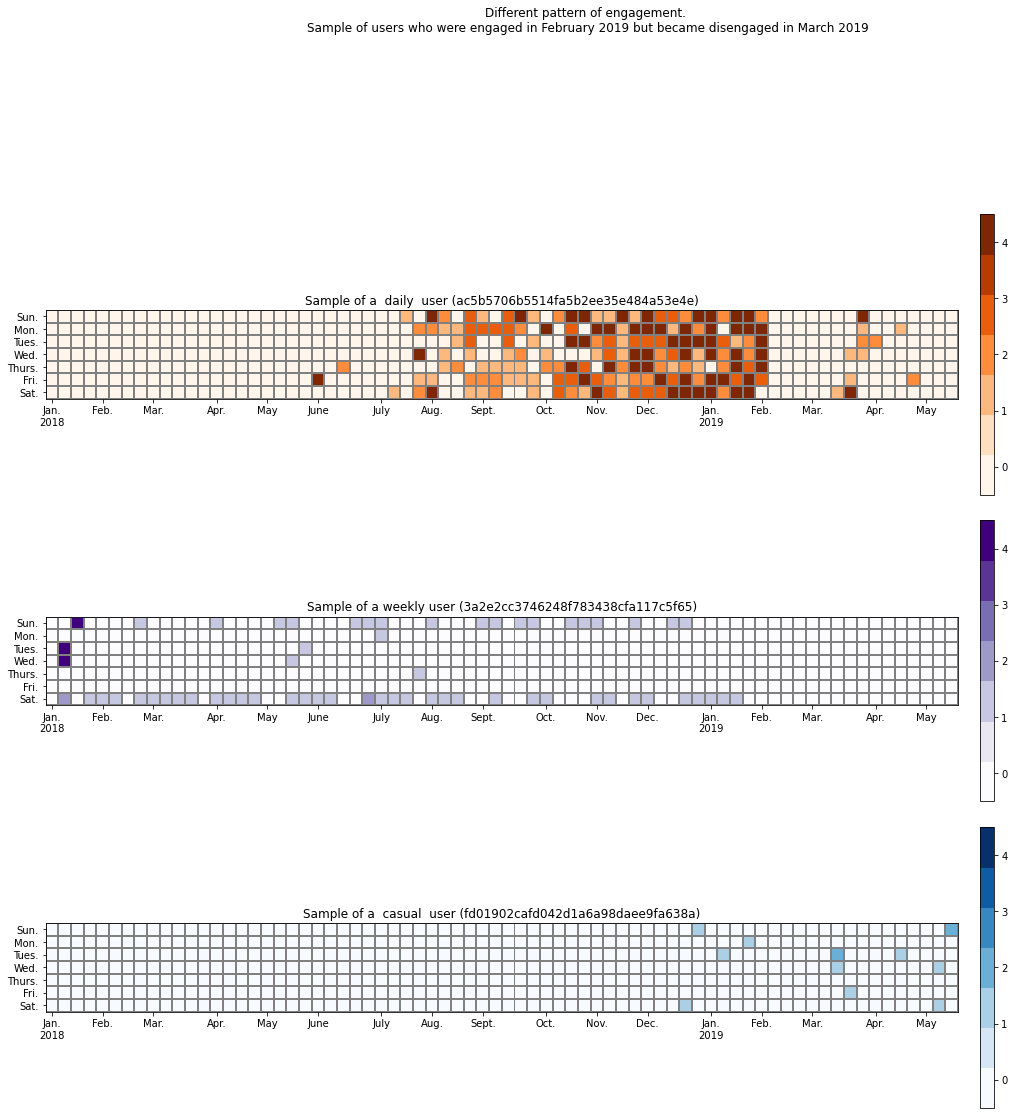

In [60]:
from fintech.viz.calendarActivity import calendarActivity
import matplotlib as mpl

daily_user = 'ac5b5706b5514fa5b2ee35e484a53e4e', 'Oranges', ' daily '
weekly_user = '3a2e2cc3746248f783438cfa117c5f65', 'Purples', 'weekly'
casual_user = 'fd01902cafd042d1a6a98daee9fa638a', 'Blues', ' casual '

fig, ax = plt.subplots(3, 1, figsize=(16, 16))
fig.tight_layout()
fig.subplots_adjust(top=0.8)
fig.suptitle("Different pattern of engagement. \n" \
             "Sample of users who were engaged in February 2019 " \
             "but became disengaged in March 2019", y=0.98)



for i, j in enumerate([daily_user, weekly_user, casual_user]):
    user_id, color, user_type = j
    calendarActivity(data=features, transaction=transaction,
                     user_id=user_id, title="Sample of a %s user (%s)" % (user_type, user_id),
                     ax=ax[i],
                     color=color)


<AxesSubplot:xlabel='median_days_between_transc', ylabel='median_monthly_transc_amount'>

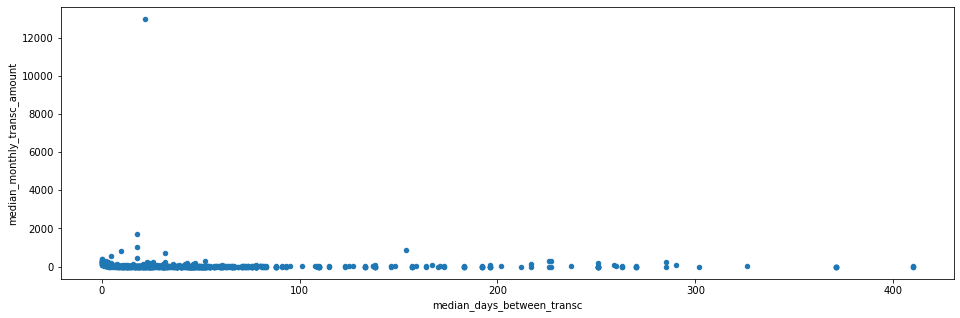

In [7]:
magic_percentile = f.expr('percentile_approx(user_transcAmountCurrMonth_total, 0.5)')
display(features.select("batch_id", "user_daysBtwTransc_50q", "user_transcAmountCurrMonth_total")
                .groupBy("batch_id", "user_daysBtwTransc_50q")
                .agg(magic_percentile.alias("median_monthly_transc_amount"))
        .withColumnRenamed("user_daysBtwTransc_50q", "median_days_between_transc")
        .toPandas()
#         .boxplot(column="user_daysBtwTransc_50q", by="user_transcAmountCurrMonth_total", figsize=(15,30), vert=False))
        .plot.scatter(x="median_days_between_transc", y="median_monthly_transc_amount", figsize=figsize))

<AxesSubplot:xlabel='user_daysBtwTransc_50q', ylabel='user_transcAmountCurrMonth_total'>

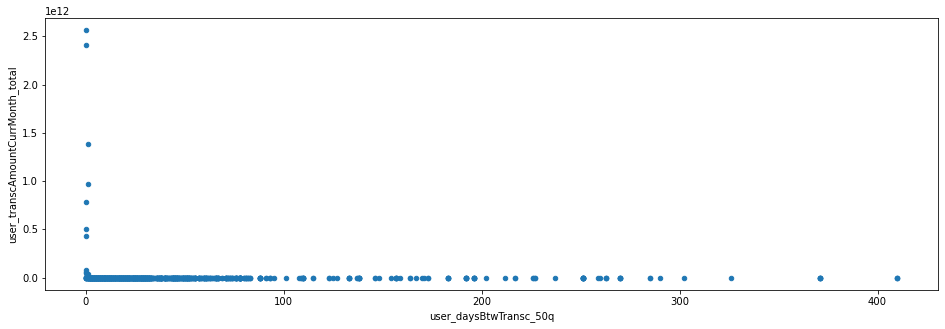

In [8]:
# # magic_percentile = f.expr('percentile_approx(user_transcAmount_avg, 0.5)')
display(features.select("batch_id", "user_daysBtwTransc_50q", "user_transcAmountCurrMonth_total")
                .groupBy("batch_id", "user_daysBtwTransc_50q")
                .agg(f.sum("user_transcAmountCurrMonth_total").alias("user_transcAmountCurrMonth_total"))
                .toPandas()
                .plot
                .scatter(x="user_daysBtwTransc_50q", y="user_transcAmountCurrMonth_total", figsize=figsize))
# features.columns

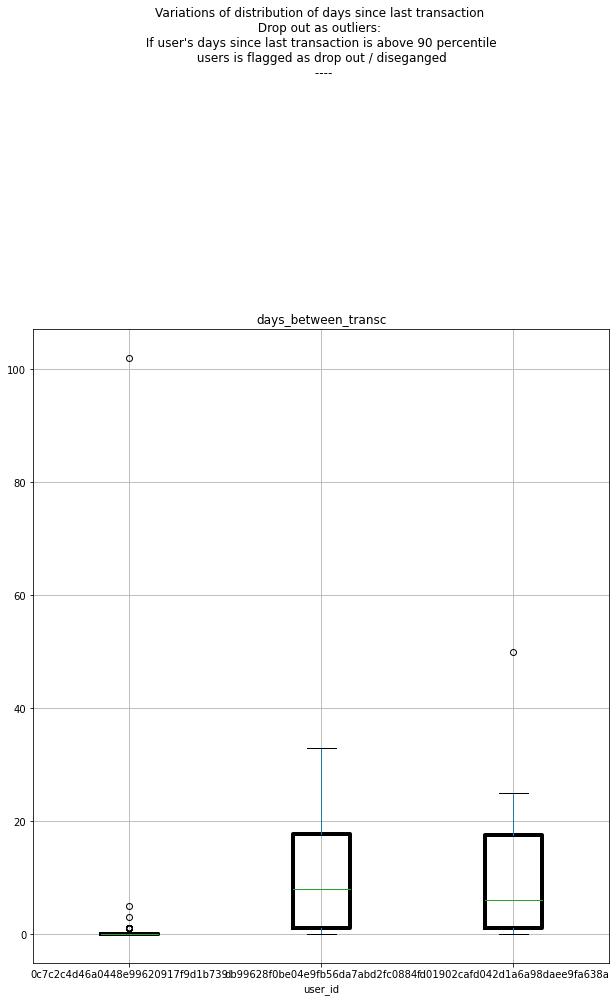

In [9]:
(transaction
 .filter(col("user_id").isin(daily_users+weekly_users+casual_users))
 .select("user_id",
         f.datediff(col("created_date"),
                    f.lag(col("created_date"), 1)
                    .over(Window.partitionBy("user_id").orderBy(col("created_date"))))
         .alias("days_between_transc"))
 .toPandas()
 .boxplot(by="user_id", column="days_between_transc", figsize=(10,16), 
          boxprops=dict(linestyle='-', linewidth=4, color='k'),
          vert=True))

plt.suptitle("Variations of distribution of days since last transaction"
             " \n Drop out as outliers: "
             " \n If user's days since last transaction is above 90 percentile"
             " \n users is flagged as drop out / diseganged \n ----", 
             y=0.98)

plt.subplots_adjust(top=0.7)

In [40]:
(transaction
 .filter(col("user_id").isin(daily_users+weekly_users+casual_users))
 .select("user_id",
         f.datediff(col("created_date"),
                    f.lag(col("created_date"), 1)
                    .over(Window.partitionBy("user_id").orderBy(col("created_date"))))
         .alias("days_between_transc"))
 .toPandas()['user_id'].unique())

array(['fd01902cafd042d1a6a98daee9fa638a',
       '0c7c2c4d46a0448e99620917f9d1b739',
       'db99628f0be04e9fb56da7abd2fc0884'], dtype=object)

In [41]:
display(features.select("batch_id", "user_id", "user_daysSinceLastTransc", 
                        col("user_daysBtwTransc_90q").alias("threshold (90 percentile)"), 
                        "user_isDropOut_currentMonth")
                        .where("user_id='0c7c2c4d46a0448e99620917f9d1b739'").limit(10).toPandas())

,batch_id,user_id,user_daysSinceLastTransc,threshold (90 percentile),user_isDropOut_currentMonth
0,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
1,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
2,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
3,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
4,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
5,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
6,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
7,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
8,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False
9,2019-01,0c7c2c4d46a0448e99620917f9d1b739,0,1,False


## Feature Diagnostic 

Text(0.5, 0.98, 'Correlation Matrix across features')

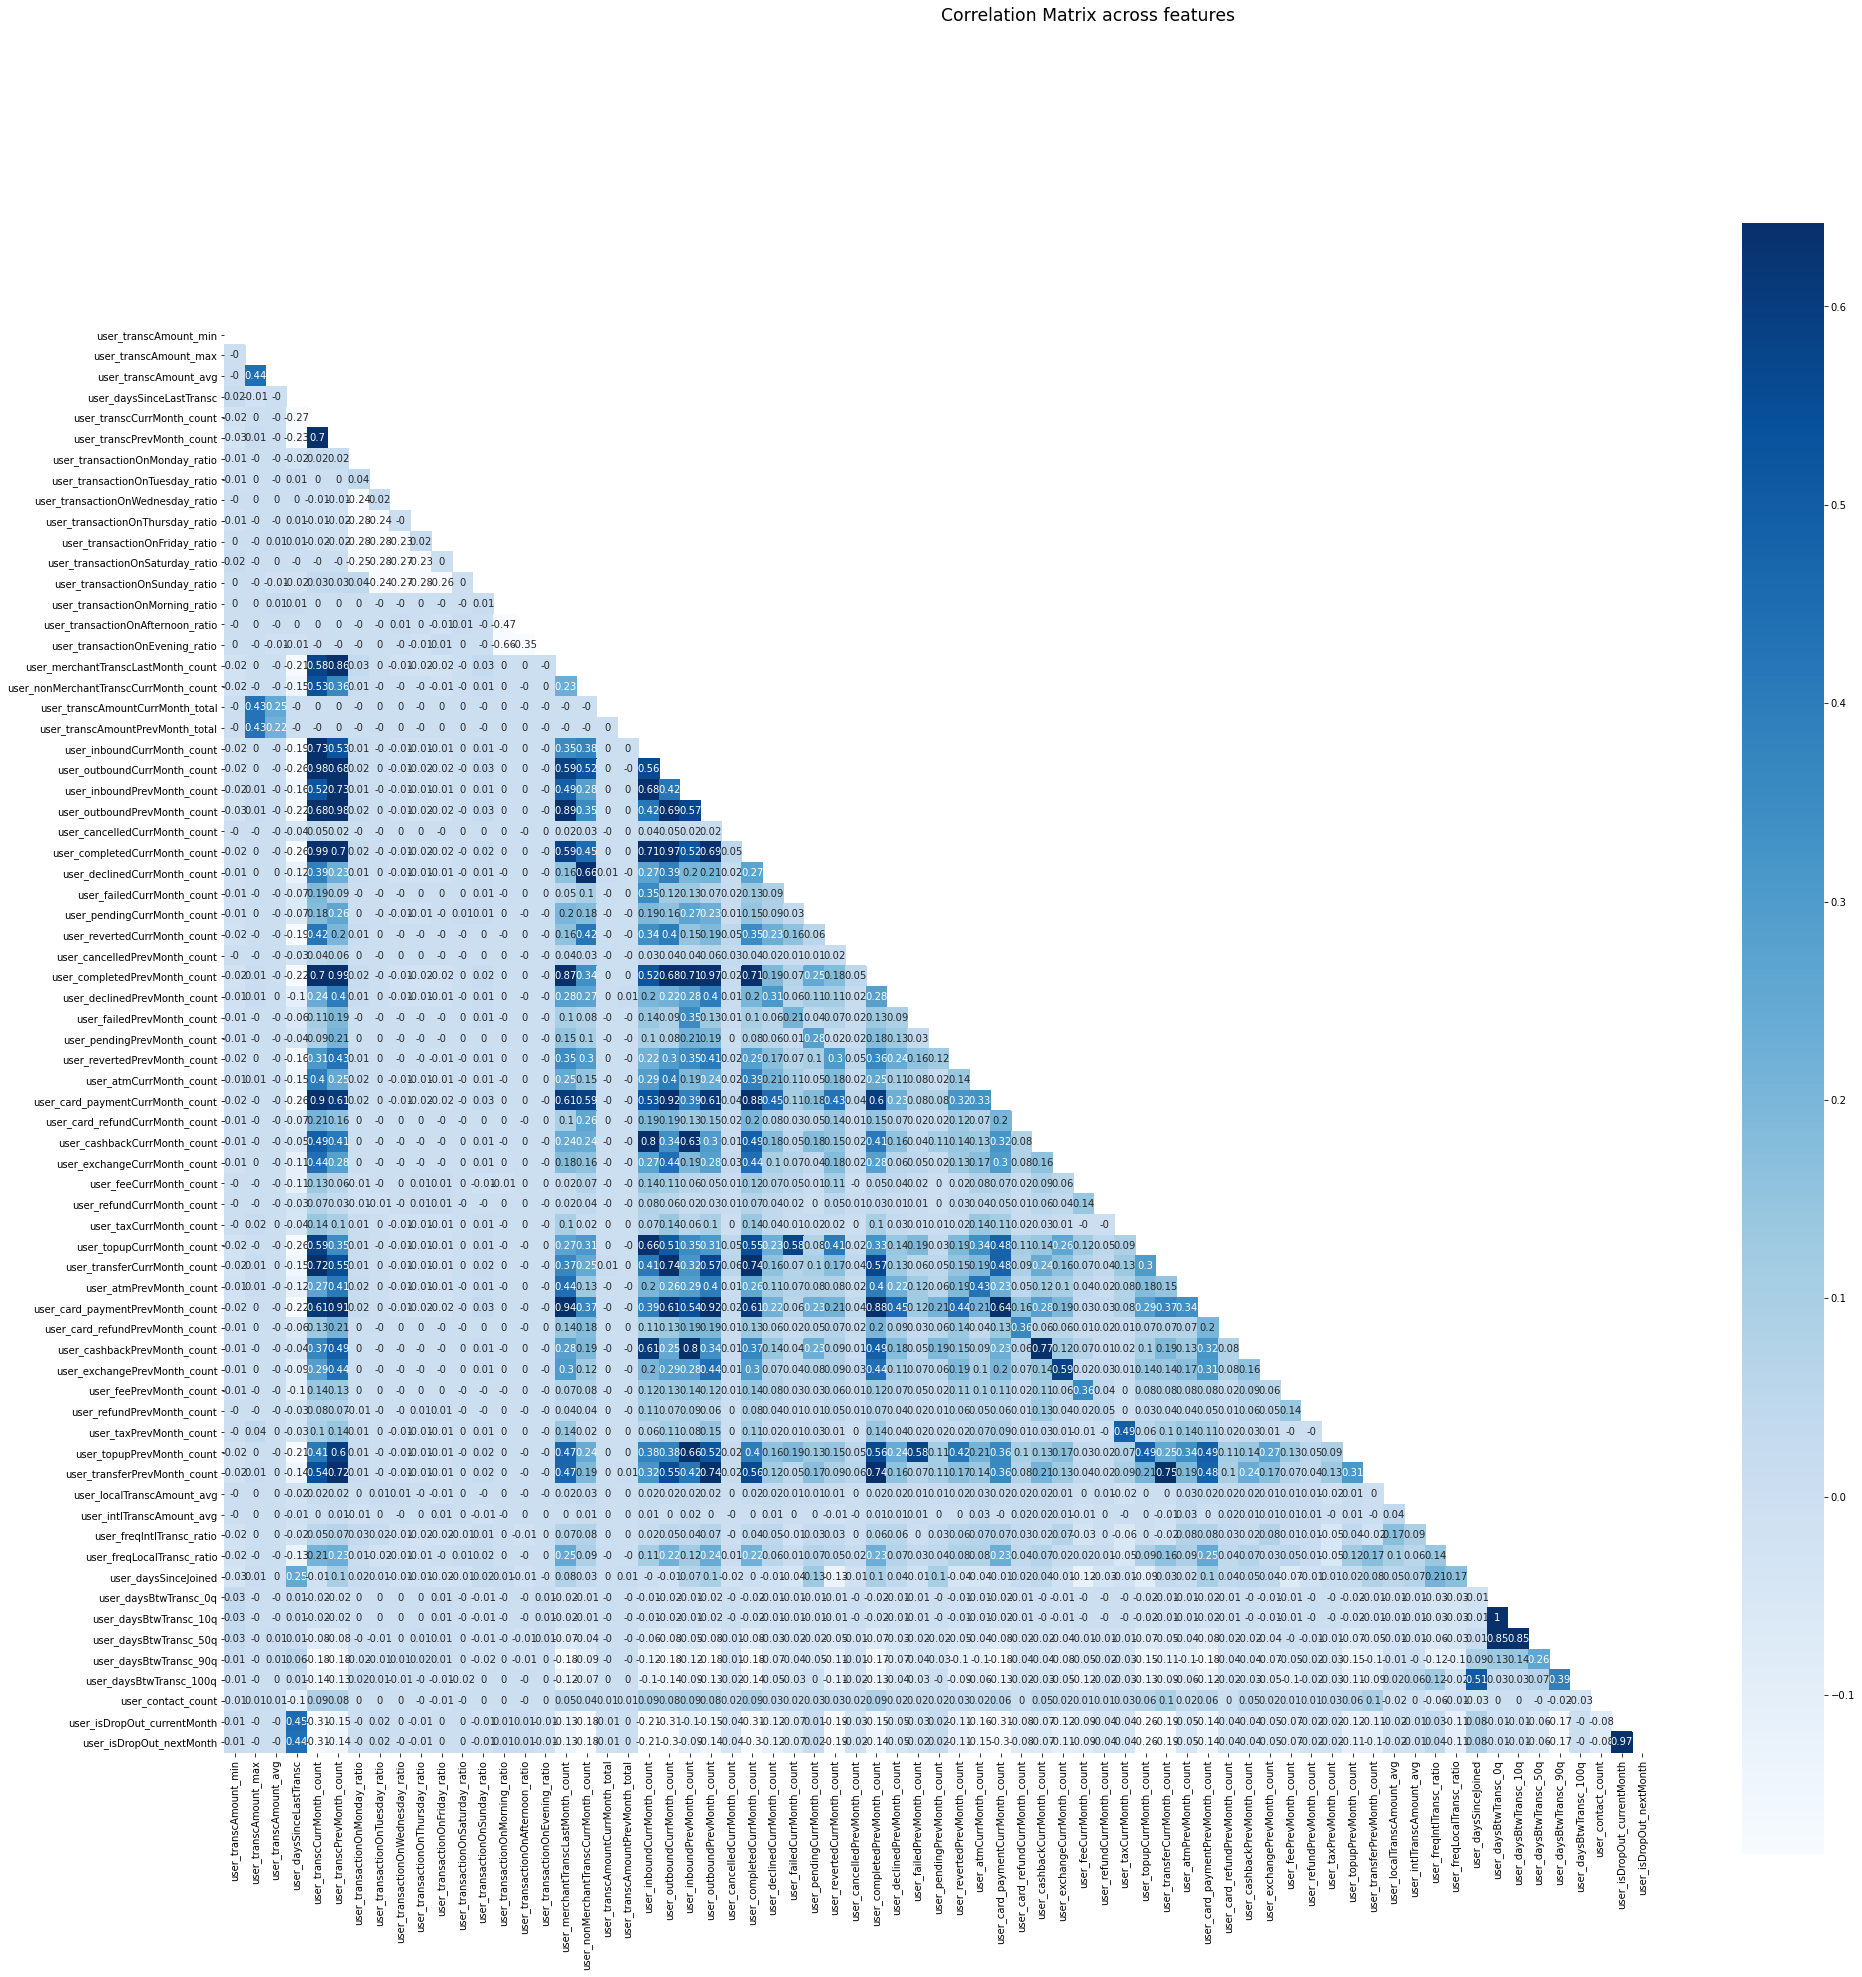

In [11]:
# features_subset = features.drop("user_id", "batch_id", *categorical)
# plt.figure(figsize=(32, 30))
# corr = round(features_subset.toPandas().corr(), 2)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# ax = sns.heatmap(corr, mask=mask, annot=True, cmap=plt.cm.Blues, robust=True, square=True)
# plt.suptitle("Correlation Matrix across features", size="xx-large")

In [12]:
display(features.where("user_id='8ef5b29cdda34cd8ab741dc3ec735d1a'").limit(10))

batch_id,user_id,user_transcAmount_min,user_transcAmount_max,user_transcAmount_avg,user_daysSinceLastTransc,user_transcCurrMonth_count,user_transcPrevMonth_count,user_transactionOnMonday_ratio,user_transactionOnTuesday_ratio,user_transactionOnWednesday_ratio,user_transactionOnThursday_ratio,user_transactionOnFriday_ratio,user_transactionOnSaturday_ratio,user_transactionOnSunday_ratio,user_transactionOnMorning_ratio,user_transactionOnAfternoon_ratio,user_transactionOnEvening_ratio,user_merchantTranscLastMonth_count,user_nonMerchantTranscCurrMonth_count,user_transcAmountCurrMonth_total,user_transcAmountPrevMonth_total,user_inboundCurrMonth_count,user_outboundCurrMonth_count,user_inboundPrevMonth_count,user_outboundPrevMonth_count,user_cancelledCurrMonth_count,user_completedCurrMonth_count,user_declinedCurrMonth_count,user_failedCurrMonth_count,user_pendingCurrMonth_count,user_revertedCurrMonth_count,user_cancelledPrevMonth_count,user_completedPrevMonth_count,user_declinedPrevMonth_count,user_failedPrevMonth_count,user_pendingPrevMonth_count,user_revertedPrevMonth_count,user_atmCurrMonth_count,user_card_paymentCurrMonth_count,user_card_refundCurrMonth_count,user_cashbackCurrMonth_count,user_exchangeCurrMonth_count,user_feeCurrMonth_count,user_refundCurrMonth_count,user_taxCurrMonth_count,user_topupCurrMonth_count,user_transferCurrMonth_count,user_atmPrevMonth_count,user_card_paymentPrevMonth_count,user_card_refundPrevMonth_count,user_cashbackPrevMonth_count,user_exchangePrevMonth_count,user_feePrevMonth_count,user_refundPrevMonth_count,user_taxPrevMonth_count,user_topupPrevMonth_count,user_transferPrevMonth_count,user_localTranscAmount_avg,user_intlTranscAmount_avg,user_freqIntlTransc_ratio,user_freqLocalTransc_ratio,user_topForeign_country,user_topMerchant_city,user_ageBucket,user_plan,user_daysSinceJoined,user_daysBtwTransc_0q,user_daysBtwTransc_10q,user_daysBtwTransc_50q,user_daysBtwTransc_90q,user_daysBtwTransc_100q,user_contact_count,user_device,user_home_city,user_home_country,user_isDropOut_currentMonth,user_isDropOut_nextMonth
2019-01,8ef5b29cdda34cd8a...,3.97,12.3,8.135,16,2,0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0,0,16.27,0.0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,N/A,N/A,e_50_to_59,STANDARD,16,1,1,1,1,1,1,Android,Lake Katrinaland,CY,true,true
2019-01,8ef5b29cdda34cd8a...,3.97,12.3,8.135,16,2,0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0,0,16.27,0.0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,N/A,N/A,d_40_to_49,STANDARD,16,1,1,1,1,1,1,Android,Lake Katrinaland,CY,true,true
2019-01,8ef5b29cdda34cd8a...,3.97,12.3,8.135,16,2,0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0,0,16.27,0.0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,N/A,N/A,c_30_to_39,STANDARD,16,1,1,1,1,1,1,Android,Lake Katrinaland,CY,true,true
2019-01,8ef5b29cdda34cd8a...,3.97,12.3,8.135,16,2,0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0,0,16.27,0.0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,N/A,N/A,c_30_to_39,STANDARD,16,1,1,1,1,1,1,Android,Lake Katrinaland,CY,true,false
2019-02,8ef5b29cdda34cd8a...,3.97,22.54,13.19,13,2,2,0.25,0.0,0.0,0.0,0.5,0.25,0.0,0.25,0.25,0.5,0,0,36.49,16.27,1,1,2,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,N/A,N/A,e_50_to_59,STANDARD,47,1,1,11,23,23,1,Android,Lake Katrinaland,CY,false,false
2019-02,8ef5b29cdda34cd8a...,3.97,22.54,13.19,13,2,2,0.25,0.0,0.0,0.0,0.5,0.25,0.0,0.25,0.25,0.5,0,0,36.49,16.27,1,1,2,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,N/A,N/A,d_40_to_49,STANDARD,47,1,1,11,23,23,1,Android,Lake Katrinaland,CY,false,false
2019-02,8ef5b29cdda34cd8a...,3.97,22.54,13.19,13,2,2,0.25,0.0,0.0,0.0,0.5,0.25,0.0,0.25,0.25,0.5,0,0,36.49,16.27,1,1,2,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,N/A,N/A,c_30_to_39,STANDARD,47,1,1,11,23,23,1,Android,La

# MODEL TRAINING

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.dummy import DummyClassifier
import warnings


batches = (features.select("batch_id")
                   .distinct()
                   .orderBy("batch_id")
                   .toPandas()["batch_id"]
                   .to_list())

metrics = {}
importances = {}

X = X.drop('user_isDropOut_currentMonth')

# Iterate through each month 
for i, batch in enumerate(batches):
    
    # Skip the first 6 months and the last month
    if i in range(0, 7) or i > 14:
        continue
    else:
        current_month = batches[:i]
        next_month = batches[i]
    s = 0.4 if i <11 else 0.3
    X_train = (X.filter(col("batch_id").isin(current_month))
                .distinct()
                .sample(False, s, 777)
                .drop("batch_id")
                .toPandas()
                .set_index("user_id"))

    X_test = (X.filter(col("batch_id") == next_month)
               .distinct()
               .sample(False, 0.6, 777)
               .drop("batch_id")
               .toPandas()
               .set_index("user_id"))

    y_train = X_train.pop("user_isDropOut_nextMonth")
    y_test = X_test.pop("user_isDropOut_nextMonth")
    feature_names = X_train.columns

    cv = StratifiedKFold(n_splits=10, random_state=777, shuffle=True)
    count_cols = [i for i in X_train.columns if i.endswith("_count")] \
                 + ["user_daysSinceLastTransc"]
    
    preprocessor = ColumnTransformer(transformers=[
        ("box_cox", PowerTransformer(), standarize),
        ("log_transform", FunctionTransformer(np.log1p), count_cols)
    ], remainder="passthrough")

    steps = [("pre", preprocessor),
             ("fs_variance", VarianceThreshold(0.0)),

             ("selectfrommodel", SelectFromModel(
                 RandomForestClassifier(n_estimators=200,
                                        n_jobs=4,
                                        random_state=777
                                        ))),

             ("RF", RandomForestClassifier(n_jobs=4,
                                           random_state=777
                                           ))]

    param_grid = [{
        "fs_variance__threshold": [0.01],
        "selectfrommodel__threshold": ["median",
                                       "1.5*median",
                                       "1.75*median"
                                      ],
        "RF__n_estimators": [250]
    }]

    hyperparams = GridSearchCV(Pipeline(steps), 
                               param_grid, n_jobs=4, 
                               cv=cv, pre_dispatch=10,
                               verbose=0, 
                               scoring="roc_auc", 
                               return_train_score=True)
    
    
    # Disable warning related to n_jobs
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore")
        hyperparams.fit(X_train, y_train)
        
        model = hyperparams.best_estimator_
        baseline = DummyClassifier(strategy="stratified").fit(X_train, y_train)

    
    test_prediction = model.predict(X_test)
    baseline_prediction = baseline.predict(X_test)
    
    
    baseline_auc = round(roc_auc_score(baseline_prediction, y_test), 2)
    train_auc = round(hyperparams.best_score_, 2)
    test_auc = round(roc_auc_score(test_prediction, y_test), 2)
    test_recall = round(recall_score(test_prediction, y_test), 2)
    test_precision = round(precision_score(test_prediction, y_test), 2)

    
    selected_features = (X_train.columns
    [model.named_steps["fs_variance"].get_support()]
    [model.named_steps["selectfrommodel"].get_support()])
    importances[batch] = (selected_features, model.named_steps["RF"].feature_importances_)

    
    metrics[batch] = [("baseline_auc", baseline_auc), 
                      ("train_auc", train_auc), 
                      ("test_auc", test_auc),
                      ("test_precision", test_precision), 
                      ("test_recall", test_recall)]

    print("train_on", "%s to %s." % (current_month[0], current_month[-1]),
          "train_auc:", train_auc,
          "| test_on:", next_month,
          "test_auc", test_auc,
          "test_precision", test_precision,
          "test_recall", test_recall)


train_on 2018-02 to 2018-08. train_auc: 0.87 | test_on: 2018-09 test_auc 0.9 test_precision 0.91 test_recall 0.91
train_on 2018-02 to 2018-09. train_auc: 0.88 | test_on: 2018-10 test_auc 0.91 test_precision 0.91 test_recall 0.91
train_on 2018-02 to 2018-10. train_auc: 0.88 | test_on: 2018-11 test_auc 0.91 test_precision 0.92 test_recall 0.91
train_on 2018-02 to 2018-11. train_auc: 0.89 | test_on: 2018-12 test_auc 0.91 test_precision 0.91 test_recall 0.91
train_on 2018-02 to 2018-12. train_auc: 0.9 | test_on: 2019-01 test_auc 0.91 test_precision 0.92 test_recall 0.9
train_on 2018-02 to 2019-01. train_auc: 0.9 | test_on: 2019-02 test_auc 0.91 test_precision 0.92 test_recall 0.91
train_on 2018-02 to 2019-02. train_auc: 0.9 | test_on: 2019-03 test_auc 0.91 test_precision 0.91 test_recall 0.91
train_on 2018-02 to 2019-03. train_auc: 0.9 | test_on: 2019-04 test_auc 0.91 test_precision 0.91 test_recall 0.92


In [38]:
with open("model/model.pkl", "wb") as file:
    pickle.dump(model, file)
with open("model/metrics.pkl", "wb") as file:
    pickle.dump(metrics, file)
with open("model/importances.pkl", "wb") as file:
    pickle.dump(importances, file)

## Model evaluation

Text(0.5, 0.98, 'Feature Importance. \n Bar: average, Boxplot: Importance Dist. across CV')

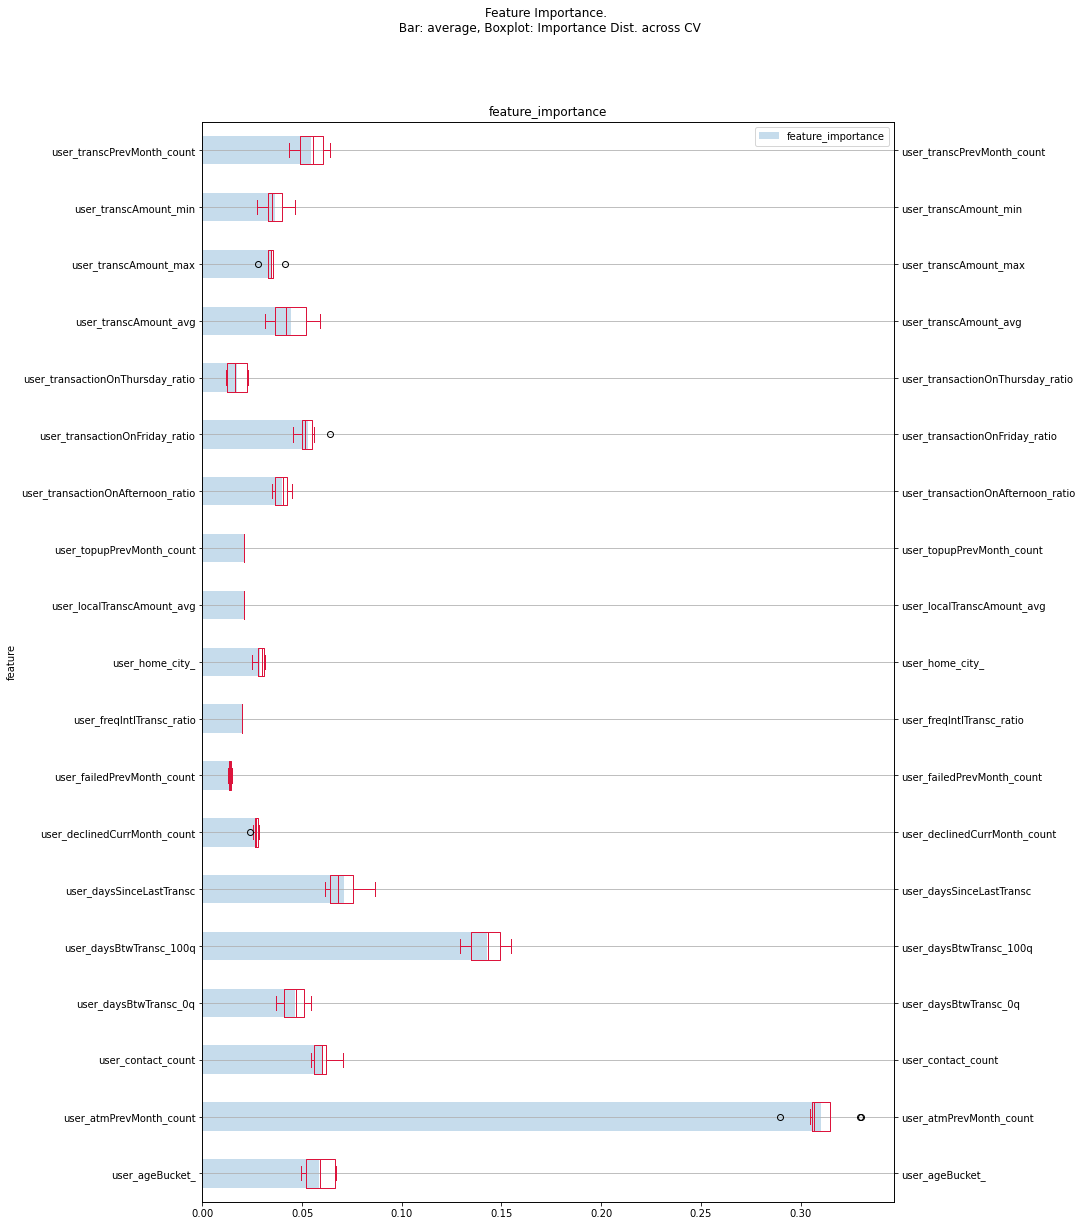

In [27]:
importance_df = None
for batch, impt in importances.items():
    if importance_df is None:
        importance_df = (pd.DataFrame(impt[1], impt[0], columns=[batch]))

    else:
        importance_df = importance_df.join(
                        pd.DataFrame(impt[1], impt[0], columns=[batch]),
                        how="outer")

feature_plot_df = (pd.DataFrame(importance_df.stack())
                   .reset_index()
                   .rename(columns={"level_0": "feature", 
                                    "level_1": "batch_id", 
                                    0: "feature_importance"}))


fig, ax = plt.subplots(1, 1, figsize=(12, 20))
ax2 = ax.twinx()


feature_plot_df.groupby("feature").mean().plot(kind="barh",
                                               ax=ax,
                                               alpha=0.25)

feature_plot_df.boxplot(by="feature",
                        column="feature_importance",
                        ax=ax2,
                        vert=False,
                        color="crimson")

fig.suptitle(
    "Feature Importance. \n Bar: average, Boxplot: Importance Dist. across CV")

In [28]:
hyperparams.best_params_

{'RF__n_estimators': 250,
 'fs_variance__threshold': 0.01,
 'selectfrommodel__threshold': '1.75*median'}

Text(0.5, 0.98, 'Model Performance \n Random Forest Classifier vs Baseline (Randomly assign based on train distribution)')

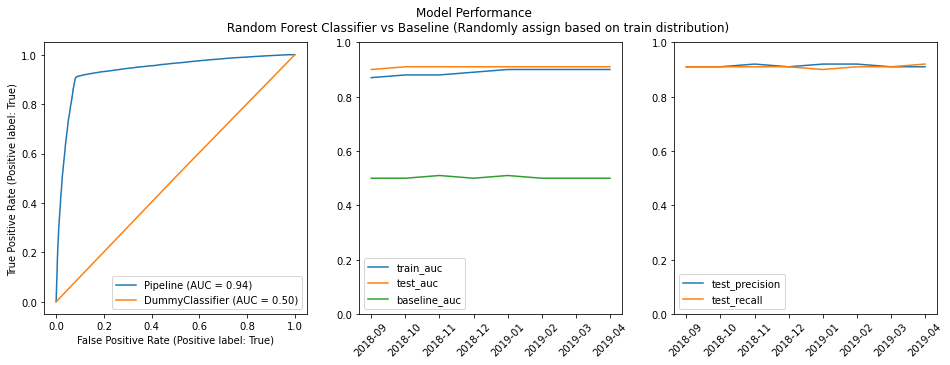

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

plot_roc_curve(model, X_test, y_test, ax=axes[0])
plot_roc_curve(baseline, X_test, y_test, ax=axes[0])

metric_df = pd.DataFrame().from_dict({k: dict(v) for k,v in metrics.items()}, orient='index')
metric_df[["train_auc", "test_auc", "baseline_auc"]].plot(ax=axes[1], ylim=(0,1))
metric_df[["test_precision", "test_recall"]].plot(ax=axes[2], ylim=(0,1))

for ax in axes[1:]:
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("Model Performance \n Random Forest Classifier vs Baseline"
             " (Randomly assign based on train distribution)")

In [30]:
metric_df.mean()

baseline_auc      0.50250
train_auc         0.89000
test_auc          0.90875
test_precision    0.91375
test_recall       0.91000
dtype: float64